In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from pathlib import Path
import re

import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.autograd import Variable


# Verificamos que CUDA está funcional
torch.cuda.is_available()

/home/tomas/.cache/pypoetry/virtualenvs/exp-tomi-2RV3BUvH-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [9]:

BASE_DIR = '/mnt/c/Users/toto_/Documents/Github/UA_MDM_LDI_II'
PATH_TO_MODELS = os.path.join(BASE_DIR, "models")
RUN_NAME =  "modelo_entrenado_20240320_120241"# "modelo_entrenado_20240319_193658" 
path_to_model =  os.path.join(PATH_TO_MODELS, f"{RUN_NAME}.pth")
PATH_TO_TEST = os.path.join(BASE_DIR, "petfinder/test/test.csv")
IMAGE_SIZE = 299

SEED = 17


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(path_to_model, map_location=device)

test_transforms = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])
                                    ])

class_names = ['0', '1', '2', '3', '4'] 

def get_inference(image_path, model, device, classes):

        image = Image.open(Path(image_path))
        # Convertir imagen en escala de grises a RGB si es necesario
        if image.mode != 'RGB':
                image = image.convert('RGB')
        image_tensor = test_transforms(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
        input = Variable(image_tensor)
        input = input.to(device)
        output = model(input)
        index = output.data.cpu().numpy().argmax()
        prob = F.softmax(output, dim=1)
        prob =  re.findall(r'\d+\.\d+', str(prob[0]))
        prob = [float(p) for p in prob]
        return classes[index], prob

In [3]:
# Prueba puntual
clase, prob = get_inference("/mnt/c/Users/toto_/Documents/Github/UA_MDM_LDI_II/petfinder/train_images/0a0e8c15b-1.jpg", model, device,class_names)

print('clase: ', clase)
print('prob: ', str(prob))

clase:  4
prob:  [0.0082, 0.0937, 0.154, 0.356, 0.3881]


**Predecimos el Test**

In [46]:
# Prueba con val_set
test_df = pd.read_csv(PATH_TO_TEST)
test_df = test_df[test_df['PhotoAmt']>0]

petid_list = []
inf_class_list = []
prob_list = []

for index, row in test_df.iterrows():
    petid = row['PetID']
    img_path = os.path.join(BASE_DIR, f"petfinder/test_images/{petid}-1.jpg")
    if os.path.exists(img_path):
        try:
            inf_class, prob = get_inference(img_path, model, device,class_names)
            petid_list.append(petid)
            inf_class_list.append(inf_class)
            prob_list.append(prob)

        except:
            print(row['PetID'])
        

test_df['Inf_Class'] = inf_class_list
test_df['Prob'] = prob_list

**Predecimos una imagen nuestra**

clase:  3
prob:  [0.0041, 0.0925, 0.3093, 0.355, 0.2391]


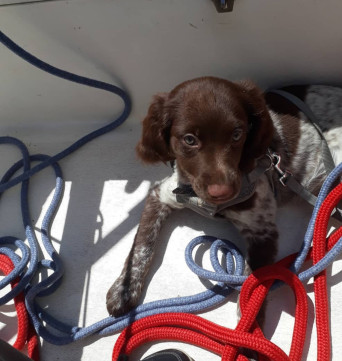

In [11]:
image_path = os.path.join(BASE_DIR, "yuval_ejemplo.jpg")
image = Image.open(Path(image_path))
inf_class, prob = get_inference(image_path, model, device,class_names)
print('clase: ', inf_class)
print('prob: ', str(prob))
image.show()